In [1]:
import numpy as np
import requests, gzip, os, hashlib
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
#fetch data
path=''
def fetch(url):
    fp = os.path.join(path, hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            data = f.read()
    else:
        with open(fp, "wb") as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

X = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28*28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [3]:
#Validation split
rand=np.arange(60000)
np.random.shuffle(rand)
train_no=rand[:50000]

val_no=np.setdiff1d(rand,train_no)

X_train,X_val=X[train_no,:,:],X[val_no,:,:]
Y_train,Y_val=Y[train_no],Y[val_no]

In [4]:
#Sigmoid funstion
def sigmoid(x):
    return 1/(np.exp(-x)+1)    

#derivative of sigmoid
def d_sigmoid(x):
    return (np.exp(-x))/((np.exp(-x)+1)**2)

In [20]:
#Softmax
def softmax(x):
    exp_element=np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)

#derivative of softmax
def d_softmax(x):
    exp_element=np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)*(1-exp_element/np.sum(exp_element,axis=0))

In [54]:
def init(x,y):
    layer=np.random.uniform(-1.,1.,size=(x,y))/np.sqrt(x*y)
    return layer.astype(np.float32)

np.random.seed(42)
l1=init(28*28,500)
l2=init(500,128)
l3=init(128,10) #10 units corresponding to digits 0–9.

In [55]:
Y_train

array([1, 0, 9, ..., 9, 6, 7], dtype=uint8)

In [44]:
ex=np.array(Y_train[1]).reshape(1,1)
ex

array([[0]], dtype=uint8)

In [56]:
example_out = np.zeros((len(ex),10), np.float32)
example_out[range(example_out.shape[0]),ex] = 1
example_out

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In the first line x is matrix multiplied with the first layer and is normalized by passing through the sigmoid function.
The sigmoid product is later matrix multiplied with the second layer and is passed through the softmax function to get the output vector of size 10, similar to our target vector.



In [89]:
#forward and backward pass
def forward_backward_pass(x,y):
    targets = np.zeros((len(y),10), np.float32)
    targets[range(targets.shape[0]),y] = 1
 
    
    x_l1=x.dot(l1)
    x_sigmoid=sigmoid(x_l1)
    x_l2=x_sigmoid.dot(l2)
    x_sigmoid1=sigmoid(x_l2)
    x_l3=x_sigmoid1.dot(l3)
    out=softmax(x_l3)
    
   
 
    error=2*(out-targets)/out.shape[0]*d_softmax(x_l3)
    update_l3=x_sigmoid1.T@error

    error=((l3).dot(error.T)).T*d_sigmoid(x_l2)
    update_l2=x_sigmoid.T@error

    
    error=((l2).dot(error.T)).T*d_sigmoid(x_l1)
    update_l1=x.T@error

    return out,update_l1,update_l2,update_l3


In [90]:
epochs=10000
lr=0.001
batch=128

losses,accuracies,val_accuracies=[],[],[]

for i in range(epochs):
    sample=np.random.randint(0,X_train.shape[0],size=(batch))
    x=X_train[sample].reshape((-1,28*28))
    y=Y_train[sample]
 

    out,update_l1,update_l2, update_l3=forward_backward_pass(x,y)
  
    category=np.argmax(out,axis=1)
    accuracy=(category==y).mean()
    accuracies.append(accuracy)
    
    loss=((category-y)**2).mean()
    losses.append(loss.item())

    
    l1=l1-lr*update_l1
    l2=l2-lr*update_l2
    l3=l3-lr*update_l3
    
    if(i%20==0):    
        X_val=X_val.reshape((-1,28*28))
        val_out=np.argmax(softmax(sigmoid(X_val.dot(l1)).dot(l2)),axis=1)
        val_acc=(val_out==Y_val).mean()
        val_accuracies.append(val_acc.item())
    if(i%500==0): print(f'For {i}th epoch: train accuracy: {accuracy:.3f} | validation accuracy:{val_acc:.3f}')




For 0th epoch: train accuracy: 0.164 | validation accuracy:0.009
For 500th epoch: train accuracy: 0.180 | validation accuracy:0.008
For 1000th epoch: train accuracy: 0.242 | validation accuracy:0.008
For 1500th epoch: train accuracy: 0.281 | validation accuracy:0.008
For 2000th epoch: train accuracy: 0.266 | validation accuracy:0.008
For 2500th epoch: train accuracy: 0.305 | validation accuracy:0.008
For 3000th epoch: train accuracy: 0.422 | validation accuracy:0.008
For 3500th epoch: train accuracy: 0.516 | validation accuracy:0.008
For 4000th epoch: train accuracy: 0.383 | validation accuracy:0.007
For 4500th epoch: train accuracy: 0.453 | validation accuracy:0.007
For 5000th epoch: train accuracy: 0.414 | validation accuracy:0.007
For 5500th epoch: train accuracy: 0.469 | validation accuracy:0.007
For 6000th epoch: train accuracy: 0.648 | validation accuracy:0.006
For 6500th epoch: train accuracy: 0.570 | validation accuracy:0.006
For 7000th epoch: train accuracy: 0.602 | validation

l1=init(28*28,500)
l2=init(500,128)
l3=init(128,10) 

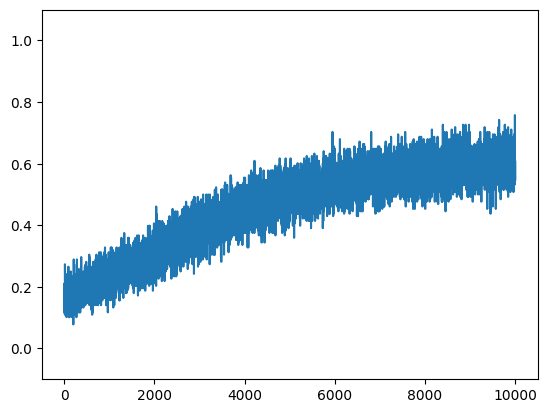

In [91]:
plt.ylim(-0.1, 1.1)
plot(accuracies)


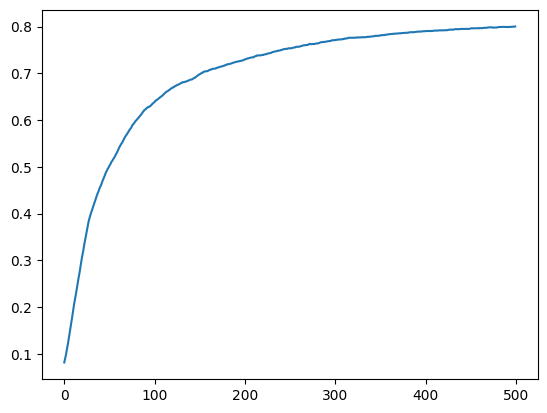

In [41]:
plot(val_accuracies)

In [41]:
test_out=np.argmax(softmax(sigmoid(X_test.dot(l1)).dot(l2)),axis=1)
test_acc=(test_out==Y_test).mean().item()
print(f'Test accuracy = {test_acc*100:.2f}%')
 

Test accuracy = 83.67%


array([7])

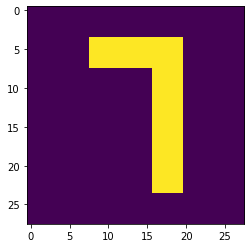

In [13]:
m = [[0,0,0,0,0,0,0],
     [0,0,10,10,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,0,0,0]]

m = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in m])
m=m.reshape(1,-1)
imshow(m.reshape(28,28))
x = np.argmax(sigmoid(m.dot(l1)).dot(l2),axis=1)
x

array([1])

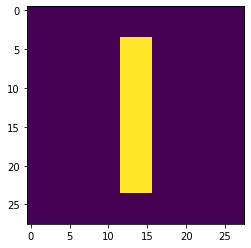

In [18]:
n = [[0,0,0,0,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,0,0,0,0]]

n = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in n])
n=n.reshape(1,-1)
imshow(n.reshape(28,28))
x = np.argmax(sigmoid(n.dot(l1)).dot(l2),axis=1)
x

In [19]:
import jovian
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Update Available: 0.2.26 --> 0.2.28
[jovian] Run `!pip install jovian --upgrade` to upgrade


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "karynaur/mnist" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Capturing environment..


[jovian] Error: Failed to read Anaconda environment using command: "conda env export -n base --no-builds"
[jovian] Error: Failed to read pip environment using command: "pip --disable-pip-version-check freeze"


[jovian] Committed successfully! https://jovian.ai/karynaur/mnist


'https://jovian.ai/karynaur/mnist'